In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet, LogisticRegression
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

from imblearn.over_sampling import SMOTE


In [2]:
import pandas as pd

# File paths
prices_file = "final_prices.csv"
balance_file = "Balance-sheet.csv"
cashflow_file = "Cash_flow.csv"
income_file = "Income_statement.csv"

# Load datasets
df_prices = pd.read_csv(prices_file)
df_balance = pd.read_csv(balance_file, sep=",")
df_cashflow = pd.read_csv(cashflow_file, sep=",")
df_income = pd.read_csv(income_file, sep=",")

# Print column names and data types
print("Stock Prices Columns:\n", df_prices.dtypes)
print("\nBalance Sheet Columns:\n", df_balance.dtypes)
print("\nCash Flow Columns:\n", df_cashflow.dtypes)
print("\nIncome Statement Columns:\n", df_income.dtypes)


Stock Prices Columns:
 Date                   object
SimFinId                int64
Open                  float64
High                  float64
Low                   float64
Close                 float64
Adj. Close            float64
Volume                  int64
Dividend              float64
Shares Outstanding    float64
Ticker                 object
dtype: object

Balance Sheet Columns:
 Ticker                                              object
Report Date                                         object
SimFinId                                             int64
Currency                                            object
Fiscal Year                                          int64
Fiscal Period                                       object
Publish Date                                        object
Restated Date                                       object
Shares (Basic)                                     float64
Shares (Diluted)                                   float64
Cash, Cash Equival

In [3]:
# Load datasets
df_prices = pd.read_csv("final_prices.csv")
df_balance = pd.read_csv("Balance-sheet.csv", sep=",")
df_cashflow = pd.read_csv("Cash_flow.csv", sep=",")
df_income = pd.read_csv("Income_statement.csv", sep=",")

# Convert 'Date' columns to datetime format
df_prices["Date"] = pd.to_datetime(df_prices["Date"])
df_balance["Report Date"] = pd.to_datetime(df_balance["Report Date"])
df_cashflow["Report Date"] = pd.to_datetime(df_cashflow["Report Date"])
df_income["Report Date"] = pd.to_datetime(df_income["Report Date"])

# Rename 'Report Date' to 'Date' for consistency
df_balance.rename(columns={"Report Date": "Date"}, inplace=True)
df_cashflow.rename(columns={"Report Date": "Date"}, inplace=True)
df_income.rename(columns={"Report Date": "Date"}, inplace=True)

# Define selected tickers
selected_tickers = ["GOOG", "META", "AAPL", "F", "NFLX"]

# Filter only selected tickers
df_prices = df_prices[df_prices["Ticker"].isin(selected_tickers)]
df_balance = df_balance[df_balance["Ticker"].isin(selected_tickers)]
df_cashflow = df_cashflow[df_cashflow["Ticker"].isin(selected_tickers)]
df_income = df_income[df_income["Ticker"].isin(selected_tickers)]

# Function to merge financials with the nearest available report date
df_merged = df_prices.merge(df_balance, on=["Ticker", "Date"], how="left", suffixes=("", "_balance"))
# Merge with cash flow data
df_merged = df_merged.merge(df_cashflow, on=["Ticker", "Date"], how="left", suffixes=("", "_cashflow"))
# Merge with income statement data
df_merged = df_merged.merge(df_income, on=["Ticker", "Date"], how="left", suffixes=("", "_income"))



In [4]:
# Create binary target variable (1 = Price Up, 0 = Price Down)
df_merged["Price_Up"] = (df_merged["Close"].shift(-1) > df_merged["Close"]).astype(int)
df_merged = df_merged[:-1]  # Drop last row since it has no next-day price

# Add technical indicators
def add_technical_indicators(df):
    df["SMA_5"] = df["Close"].rolling(window=5).mean()
    df["SMA_10"] = df["Close"].rolling(window=10).mean()
    df["RSI_14"] = compute_rsi(df["Close"], 14)
    return df

def compute_rsi(series, window):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_merged = add_technical_indicators(df_merged)

# Drop non-numeric columns except 'Price_Up'
df_final = df_merged.select_dtypes(include=[np.number])


In [5]:
df_final = df_final.dropna(axis=1, how='all')

df_final["Dividend"].fillna(0, inplace=True)


df_final.fillna(method="ffill", inplace=True)
df_final.fillna(method="bfill", inplace=True)

C:\Users\Apoorv\AppData\Local\Temp\ipykernel_59984\141335596.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final["Dividend"].fillna(0, inplace=True)
C:\Users\Apoorv\AppData\Local\Temp\ipykernel_59984\141335596.py:6: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final.fillna(method="ffill", inplace=True)
C:\Users\Apoorv\AppData\Local\Temp\ipykernel_59984\141335596.py:7: FutureWarning: DataFrame.fillna with 'method' is depreca

In [6]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 78 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   SimFinId                                         6194 non-null   int64  
 1   Open                                             6194 non-null   float64
 2   High                                             6194 non-null   float64
 3   Low                                              6194 non-null   float64
 4   Close                                            6194 non-null   float64
 5   Adj. Close                                       6194 non-null   float64
 6   Volume                                           6194 non-null   int64  
 7   Dividend                                         6194 non-null   float64
 8   Shares Outstanding                               6194 non-null   float64
 9   SimFinId_balance              

In [7]:
# Get unique tickers
company_tickers = df_merged["Ticker"].unique()

# Create a dictionary to store separate DataFrames for each company
company_datasets = {}

for ticker in company_tickers:
    company_datasets[ticker] = df_final[df_merged["Ticker"] == ticker].copy()



In [8]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# Dictionary to store trained models for each company
company_models = {}

for ticker, df_company in company_datasets.items():
    print(f"\nProcessing {ticker}...")

    # Separate target variable
    y = df_company["Price_Up"]
    X = df_company.drop(columns=["Price_Up"])

    # Feature Scaling
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Feature Selection using ElasticNet
    param_grid = {'alpha': [0.0001, 0.001, 0.01], 'l1_ratio': [0.3, 0.5, 0.7]}
    grid_search = GridSearchCV(ElasticNet(max_iter=10000), param_grid, cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_scaled, y)

    # Select important features
    best_elastic_net = grid_search.best_estimator_
    selected_features = X_scaled.columns[best_elastic_net.coef_ != 0]
    X_selected = X_scaled[selected_features]

    print(f"Selected Features for {ticker}: {selected_features.tolist()}")

    # Handle class imbalance
    smote = SMOTE(sampling_strategy="auto", random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y)

    # Store processed dataset
    company_datasets[ticker] = (X_resampled, y_resampled)




Processing GOOG...
Selected Features for GOOG: ['Close', 'Adj. Close', 'Shares (Diluted)', 'Inventories', 'Share Capital & Additional Paid-In Capital', 'Shares (Diluted)_cashflow', 'Depreciation & Amortization', 'Change in Other', 'Change in Fixed Assets & Intangibles', 'Shares (Diluted)_income', 'RSI_14']

Processing META...
Selected Features for META: ['Close', 'Adj. Close', 'Volume', 'Dividend', 'Inventories', 'Total Noncurrent Liabilities', 'Net Income/Starting Line', 'Change in Accounts Receivable', 'Net Cash from Financing Activities', 'Net Change in Cash', 'Income (Loss) from Continuing Operations', 'Net Income', 'Net Income (Common)', 'RSI_14']

Processing AAPL...
Selected Features for AAPL: ['Open', 'Close', 'Dividend', 'Short Term Debt', 'Depreciation & Amortization', 'Non-Cash Items', 'Change in Working Capital', 'Net Cash from Operating Activities', 'Net Cash from Acquisitions & Divestitures', 'Net Cash from Investing Activities', 'Selling, General & Administrative', 'RSI_

In [9]:
for ticker, (X_train, y_train) in company_datasets.items():
    print(f"\nClass distribution for {ticker}:")
    print(pd.Series(y_train).value_counts())



Class distribution for GOOG:
Price_Up
1    671
0    671
Name: count, dtype: int64

Class distribution for META:
Price_Up
1    644
0    644
Name: count, dtype: int64

Class distribution for AAPL:
Price_Up
1    647
0    647
Name: count, dtype: int64

Class distribution for F:
Price_Up
1    639
0    639
Name: count, dtype: int64

Class distribution for NFLX:
Price_Up
1    631
0    631
Name: count, dtype: int64


In [10]:
from sklearn.ensemble import RandomForestClassifier

for ticker, (X_train, y_train) in company_datasets.items():
    print(f"\nTraining model for {ticker}...")

    # Try Logistic Regression first
    log_reg = LogisticRegression(max_iter=5000, class_weight="balanced")

    param_grid_log = {
        "C": [0.01, 0.1, 1, 10, 100],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear", "saga"]
    }

    grid_search_log = GridSearchCV(log_reg, param_grid_log, cv=5, scoring="roc_auc", n_jobs=-1)
    grid_search_log.fit(X_train, y_train)

    best_log_reg = grid_search_log.best_estimator_

    # Check if Logistic Regression is failing
    y_proba_log = best_log_reg.predict_proba(X_train)[:, 1]

    if len(np.unique(y_proba_log)) == 1:  # Logistic Regression fails (all 0.5)
        print(f"⚠️ Logistic Regression failed for {ticker}. Switching to RandomForest...")

        # Train RandomForestClassifier
        rf_model = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42, class_weight="balanced")
        rf_model.fit(X_train, y_train)

        company_models[ticker] = rf_model
        print(f"✅ RandomForest model trained for {ticker}.")
    else:
        company_models[ticker] = best_log_reg
        print(f"✅ Best Logistic Regression model selected for {ticker}.")





Training model for GOOG...
⚠️ Logistic Regression failed for GOOG. Switching to RandomForest...
✅ RandomForest model trained for GOOG.

Training model for META...
⚠️ Logistic Regression failed for META. Switching to RandomForest...
✅ RandomForest model trained for META.

Training model for AAPL...
⚠️ Logistic Regression failed for AAPL. Switching to RandomForest...
✅ RandomForest model trained for AAPL.

Training model for F...
⚠️ Logistic Regression failed for F. Switching to RandomForest...
✅ RandomForest model trained for F.

Training model for NFLX...
✅ Best Logistic Regression model selected for NFLX.


In [11]:
for ticker, model in company_models.items():
    print(f"\nOptimizing threshold for {ticker}...")

    # Fix: Extract only first two elements
    X_test, y_test = company_datasets[ticker][:2]

    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    if len(np.unique(y_proba)) == 1:  # Fix for "all 0.5" issue
        optimal_threshold = 0.5
        print(f"Warning: {ticker} has only one probability value. Using default threshold = 0.5.")
    else:
        optimal_threshold = thresholds[(tpr - fpr).argmax()]

    y_pred_adjusted = (y_proba >= optimal_threshold).astype(int)
    company_datasets[ticker] = (X_test, y_test)  # Store only two elements

    print(f"Optimal Threshold for {ticker}: {optimal_threshold:.2f}")






Optimizing threshold for GOOG...
Optimal Threshold for GOOG: 0.50

Optimizing threshold for META...
Optimal Threshold for META: 0.52

Optimizing threshold for AAPL...
Optimal Threshold for AAPL: 0.48

Optimizing threshold for F...
Optimal Threshold for F: 0.51

Optimizing threshold for NFLX...
Optimal Threshold for NFLX: 0.49


In [12]:
for ticker, (X_test, y_test) in company_datasets.items():  # Unpack all 3 values
    print(f"\nChecking predictions for {ticker}...")

    y_proba = company_models[ticker].predict_proba(X_test)[:, 1]

    print("Min Probability:", y_proba.min())
    print("Max Probability:", y_proba.max())
    print("Unique Values in Predictions:", np.unique(y_proba))



Checking predictions for GOOG...
Min Probability: 0.2540137256899164
Max Probability: 0.755919238425402
Unique Values in Predictions: [0.25401373 0.27464004 0.27468251 ... 0.74628961 0.75300193 0.75591924]

Checking predictions for META...
Min Probability: 0.29774310313027647
Max Probability: 0.7555555517969813
Unique Values in Predictions: [0.2977431  0.30116105 0.30895782 ... 0.72066367 0.73011221 0.75555555]

Checking predictions for AAPL...
Min Probability: 0.2549149966831701
Max Probability: 0.6623300287089325
Unique Values in Predictions: [0.254915   0.26084378 0.26582674 ... 0.6563353  0.65826748 0.66233003]

Checking predictions for F...
Min Probability: 0.15905449103274683
Max Probability: 0.7387705461199566
Unique Values in Predictions: [0.15905449 0.16509851 0.19001487 ... 0.73425134 0.73704499 0.73877055]

Checking predictions for NFLX...
Min Probability: 0.06140909889844477
Max Probability: 0.6547805997163396
Unique Values in Predictions: [0.0614091  0.16102141 0.23488916


Model Evaluation for GOOG:

              precision    recall  f1-score   support

           0       0.69      0.68      0.69       671
           1       0.69      0.70      0.69       671

    accuracy                           0.69      1342
   macro avg       0.69      0.69      0.69      1342
weighted avg       0.69      0.69      0.69      1342

ROC-AUC Score: 0.6893


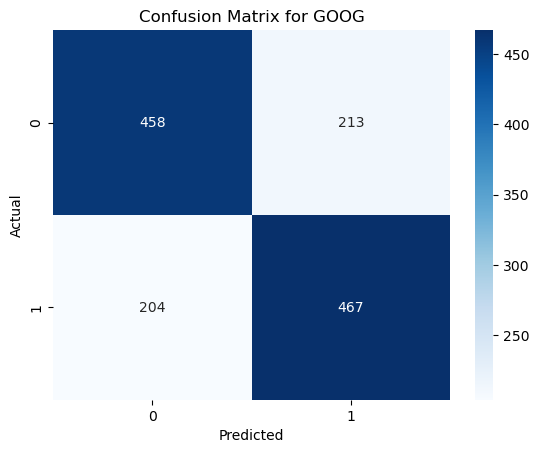


Model Evaluation for META:

              precision    recall  f1-score   support

           0       0.69      0.66      0.68       644
           1       0.68      0.71      0.69       644

    accuracy                           0.68      1288
   macro avg       0.69      0.68      0.68      1288
weighted avg       0.69      0.68      0.68      1288

ROC-AUC Score: 0.6848


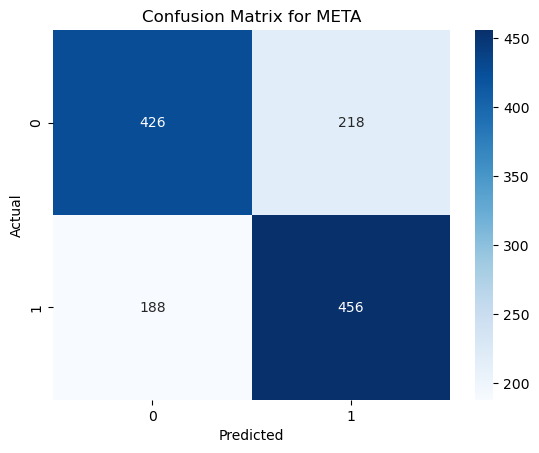


Model Evaluation for AAPL:

              precision    recall  f1-score   support

           0       0.68      0.69      0.69       647
           1       0.69      0.68      0.68       647

    accuracy                           0.69      1294
   macro avg       0.69      0.69      0.69      1294
weighted avg       0.69      0.69      0.69      1294

ROC-AUC Score: 0.6870


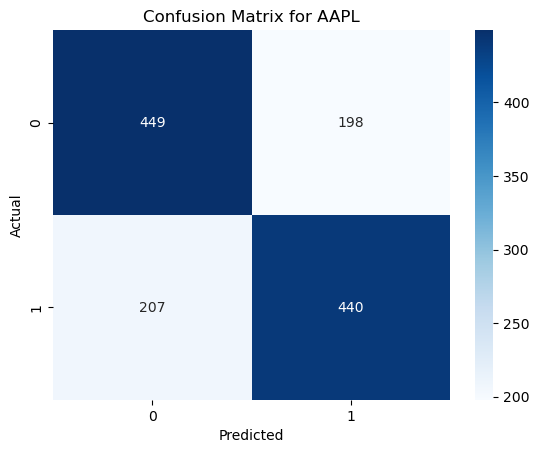


Model Evaluation for F:

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       639
           1       0.65      0.71      0.68       639

    accuracy                           0.66      1278
   macro avg       0.66      0.66      0.66      1278
weighted avg       0.66      0.66      0.66      1278

ROC-AUC Score: 0.6620


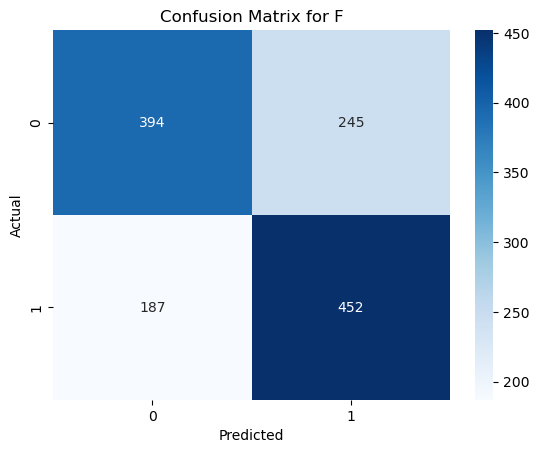


Model Evaluation for NFLX:

              precision    recall  f1-score   support

           0       0.57      0.54      0.55       631
           1       0.56      0.58      0.57       631

    accuracy                           0.56      1262
   macro avg       0.56      0.56      0.56      1262
weighted avg       0.56      0.56      0.56      1262

ROC-AUC Score: 0.5626


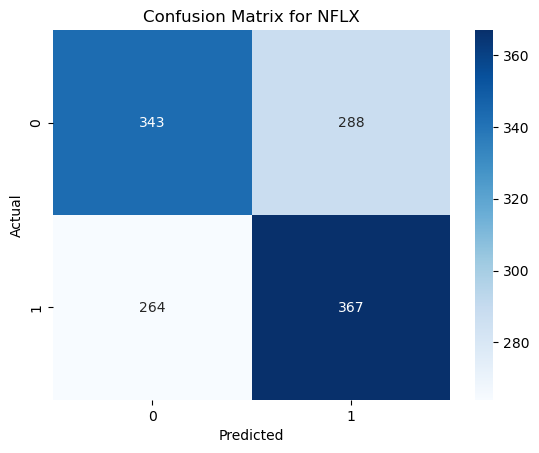

In [13]:
for ticker, (X_test, y_test) in company_datasets.items():
    print(f"\nModel Evaluation for {ticker}:\n")

    # Compute predictions again
    y_pred = (company_models[ticker].predict_proba(X_test)[:, 1] >= 0.5).astype(int)

    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.4f}")

    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {ticker}")
    plt.show()


   


In [14]:
import joblib
import os

# Create a folder to store models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Save models
for ticker, model in company_models.items():
    model_filename = f"saved_models/{ticker}_model.pkl"
    joblib.dump(model, model_filename)
    print(f"✅ Model for {ticker} saved as {model_filename}")


✅ Model for GOOG saved as saved_models/GOOG_model.pkl
✅ Model for META saved as saved_models/META_model.pkl
✅ Model for AAPL saved as saved_models/AAPL_model.pkl
✅ Model for F saved as saved_models/F_model.pkl
✅ Model for NFLX saved as saved_models/NFLX_model.pkl
